<a href="https://colab.research.google.com/github/Biruk-gebru/RNNTraining-/blob/main/RNNTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle

from google.colab import files
files.upload()


import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d kaggle/us-baby-names
!unzip us-baby-names.zip -d baby_names


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kaggle/us-baby-names
License(s): CC0-1.0
 68% 117M/173M [00:00<00:00, 1.22GB/s]
100% 173M/173M [00:00<00:00, 870MB/s] 
Archive:  us-baby-names.zip
  inflating: baby_names/NationalNames.csv  
  inflating: baby_names/NationalReadMe.pdf  
  inflating: baby_names/StateNames.csv  
  inflating: baby_names/StateReadMe.pdf  
  inflating: baby_names/database.sqlite  
  inflating: baby_names/hashes.txt   


   Id       Name  Year Gender  Count
0   1       Mary  1880      F   7065
1   2       Anna  1880      F   2604
2   3       Emma  1880      F   2003
3   4  Elizabeth  1880      F   1939
4   5     Minnie  1880      F   1746
🚀 Total unique names: 93889


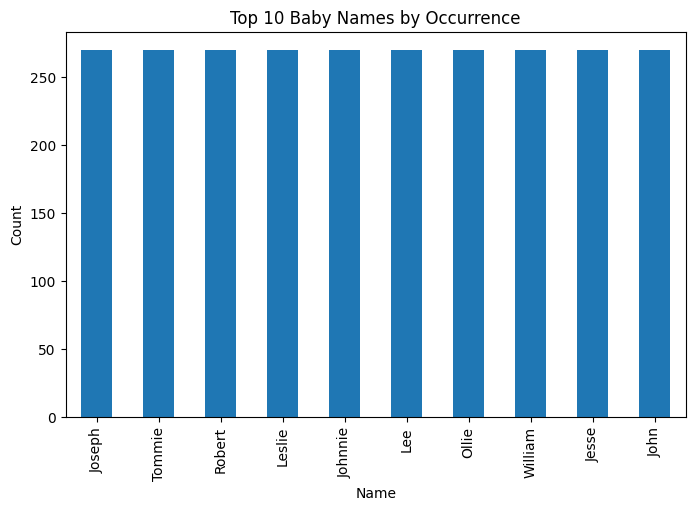

In [4]:
import pandas as pd
df = pd.read_csv('baby_names/NationalNames.csv')
print(df.head())

print("🚀 Total unique names:", df['Name'].nunique())


top_names = df['Name'].value_counts().head(10)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
top_names.plot(kind='bar')
plt.title("Top 10 Baby Names by Occurrence")
plt.ylabel("Count")
plt.show()


In [5]:
import string, torch
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)

def clean_name(name):
    return ''.join(c for c in name if c in all_letters)

names = df['Name'].dropna().astype(str).map(clean_name)
names = names[names.str.len() > 1].unique().tolist()
print(f"Filtered names: {len(names)}")

# Character→index & tensor helpers
def letter_to_index(letter): return all_letters.find(letter)
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, l in enumerate(line):
        tensor[li][0][letter_to_index(l)] = 1
    return tensor


Filtered names: 93889


In [6]:
def character_accuracy(model, val_names):
    model.eval()
    total_chars = 0
    correct_chars = 0

    with torch.no_grad():
        for name in val_names:
            name = name.strip()
            if len(name) < 2:
                continue
            input_seq = line_to_tensor(name[:-1])
            target_seq = [letter_to_index(c) for c in name[1:]]
            hidden = model.initHidden()
            for i in range(len(input_seq)):
                output, hidden = model(input_seq[i], hidden)
                pred_idx = output.argmax(dim=1).item()
                if pred_idx == target_seq[i]:
                    correct_chars += 1
                total_chars += 1

    return correct_chars / total_chars if total_chars > 0 else 0


In [7]:
import torch.nn as nn, torch.optim as optim, random
from torch.nn.utils import clip_grad_norm_

class NameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inp, hidden):
        combined = torch.cat((inp, hidden), 1)
        hidden = self.i2h(combined)
        out = self.softmax(self.i2o(combined))
        return out, hidden

    def initHidden(self): return torch.zeros(1, self.hidden_size)

# Training setup
def random_pair():
    name = random.choice(names)
    input_seq = line_to_tensor(name[:-1])
    target = torch.tensor([letter_to_index(c) for c in name[1:]], dtype=torch.long)
    return input_seq, target

model = NameRNN(n_letters, 128, n_letters)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.NLLLoss()

# Train with gradient clipping and loss logging
import time
epochs, print_every, total_loss, all_losses = 2000, 200, 0, []
all_losses = []
char_accuracies = []

for i in range(1, epochs + 1):
    inp, tgt = random_pair()
    hidden = model.initHidden()
    optimizer.zero_grad()
    loss = sum(criterion(model(inp[j], hidden)[0], tgt[j].unsqueeze(0)) for j in range(inp.size(0)))
    loss.backward()
    clip_grad_norm_(model.parameters(), 5)
    optimizer.step()
    total_loss += loss.item() / inp.size(0)

    if i % print_every == 0:
        avg = total_loss / print_every
        all_losses.append(avg)
        val_names = random.sample(names, 200)
        acc = character_accuracy(model, val_names)
        char_accuracies.append(acc)
        print(f"[{i}/{epochs}] Loss: {avg:.4f} | Accuracy: {acc:.4f}")
        total_loss = 0


[200/2000] Loss: 3.5165 | Accuracy: 0.2025
[400/2000] Loss: 2.8751 | Accuracy: 0.2313
[600/2000] Loss: 2.6342 | Accuracy: 0.2438
[800/2000] Loss: 2.5457 | Accuracy: 0.2425
[1000/2000] Loss: 2.5136 | Accuracy: 0.2476
[1200/2000] Loss: 2.4663 | Accuracy: 0.2550
[1400/2000] Loss: 2.3804 | Accuracy: 0.2582
[1600/2000] Loss: 2.3790 | Accuracy: 0.2657
[1800/2000] Loss: 2.3822 | Accuracy: 0.2543
[2000/2000] Loss: 2.3969 | Accuracy: 0.2613


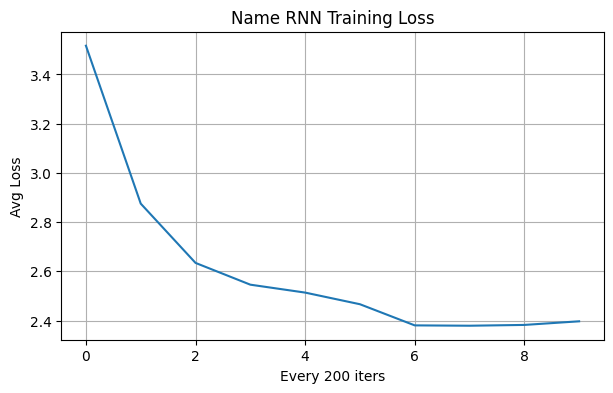

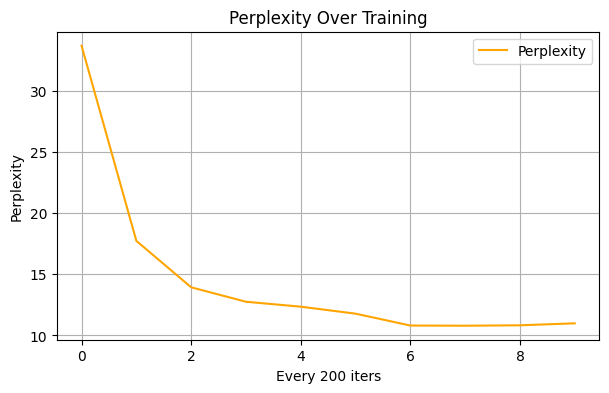

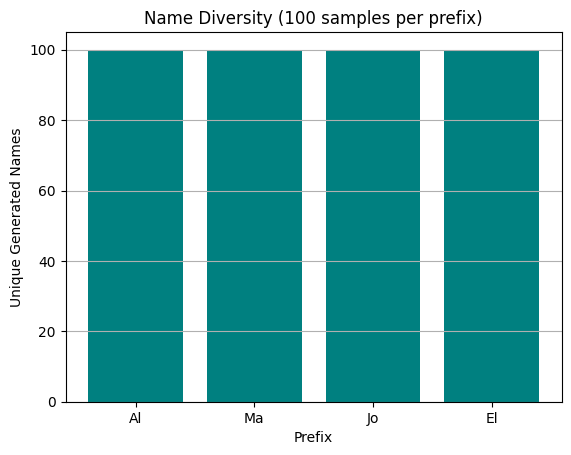

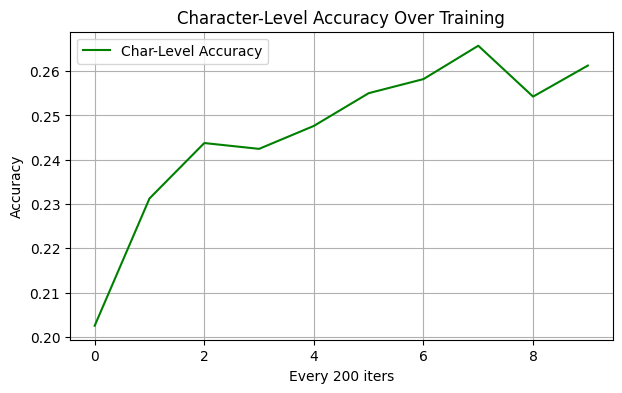

In [11]:
import numpy as np

plt.figure(figsize=(7,4))
plt.plot(all_losses)
plt.title("Name RNN Training Loss")
plt.xlabel(f"Every {print_every} iters")
plt.ylabel("Avg Loss")
plt.grid()
plt.show()


perplexities = [np.exp(l) for l in all_losses]

plt.figure(figsize=(7,4))
plt.plot(perplexities, label="Perplexity", color="orange")
plt.title("Perplexity Over Training")
plt.xlabel(f"Every {print_every} iters")
plt.ylabel("Perplexity")
plt.grid()
plt.legend()
plt.show()


prefixes = ["Al", "Ma", "Jo", "El"]
diversities = {}

for prefix in prefixes:
    samples = [generate_sample(prefix, temperature=0.8) for _ in range(100)]
    diversities[prefix] = len(set(samples))

plt.bar(diversities.keys(), diversities.values(), color="teal")
plt.title("Name Diversity (100 samples per prefix)")
plt.ylabel("Unique Generated Names")
plt.xlabel("Prefix")
plt.grid(axis='y')
plt.show()


plt.figure(figsize=(7,4))
plt.plot(char_accuracies, label="Char-Level Accuracy", color="green")
plt.title("Character-Level Accuracy Over Training")
plt.xlabel(f"Every {print_every} iters")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()





In [9]:
import torch.nn.functional as F

def generate_sample(prefix, max_len=20, temperature=0.8):
    with torch.no_grad():
        hidden = model.initHidden()
        output = prefix

        for p in prefix[:-1]:
            _, hidden = model(letter_to_tensor(p), hidden)

        inp = letter_to_tensor(prefix[-1])
        for _ in range(max_len):
            out, hidden = model(inp, hidden)
            out_dist = F.softmax(out / temperature, dim=1)
            top_i = torch.multinomial(out_dist, 1)[0][0].item()
            char = all_letters[top_i]
            if char == '\n':
                break
            output += char
            inp = letter_to_tensor(char)
        return output


for prefix in ["Jo", "Ab", "Mar", "El"]:
    samples = [generate_sample(prefix, temperature=0.7) for _ in range(5)]
    print(f"{prefix} →", ", ".join(samples))



Jo → Jorinaariyionniarienan, Jorenantarolyanuljaqii, Joarienishaeiobisaleea, Josmehaharickauamadaro, Jonetrarlaleleteamiyre
Ab → Abyallinatresheneandau, Abiellererydrifayalles, Abiesthkahatheelselals, Abankavetaryshaharinhi, Abeletryilaraiaanarina
Mar → Mariareerryainyonanalla, Mararthereleenahenaleya, Marmlecimalelasiaruital, Marisieniceroreonjannia, Mareennindinenelliealay
El → Elyanamarronnarishinnn, Eletarahammeesucharesh, Elelarilenennaraleisha, Elyrolanarishaharahenn, Elelorrerrendaronesham


In [10]:
# Diversity: how many unique names from same prefix
prefix = "Mar"
samples = [generate_sample(prefix) for _ in range(100)]
unique = len(set(samples))
print(f"Diversity for '{prefix}': {unique}/100 unique names")


Diversity for 'Mar': 100/100 unique names


In [12]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "name_rnn.pth")
!cp name_rnn.pth /content/drive/MyDrive/
print("✅ Model saved to Google Drive")


Mounted at /content/drive
✅ Model saved to Google Drive
